# SHAP Analysis

В данной фазе используется SHAP (SHapley Additive exPlanations) для интерпретации модели Random Forest.

**Цель** - понять, какие признаки вносят наибольший вклад в классификацию высокого уровня стресса, а также рассмотреть индивидуальные сценарии “what-if”.

### Зачем вообще нужен SHAP

На предыдущем этапе проекта была обучена модель машинного обучения,которая умеет определять, находится ли человек в группе высокого стрессана основе его повседневных привычек и психоэмоциональных показателей.

Однако сама по себе модель отвечает только на вопрос **«какой результат»**, но не объясняет **«почему был получен именно такой результат»**.

SHAP (SHapley Additive exPlanations) используется для того, чтобы:
- сделать выводы модели прозрачными;
- понять, какие факторы реально повлияли на решение;
- интерпретировать модель не как «чёрный ящик», а как объяснимый инструмент.

Иными словами, SHAP переводит решение модели с языка алгоритмов на понятный человеку язык.

### Как работает SHAP 

SHAP основан на идее справедливого распределения вклада.

Модель принимает решение, опираясь сразу на множество признаков (сон, тревожность, усталость, экранное время и т.д.).
SHAP поочерёдно анализирует вклад каждого признака и оценивает, насколько сильно он изменяет итоговый результат.

В результате:
- каждый признак получает числовой вклад;
- положительный вклад увеличивает вероятность высокого стресса;
- отрицательный вклад снижает её.

Сумма всех вкладов формирует финальное решение модели.

## Повтор модели Random Forest

### Импорт библиотек

In [ ]:
import os
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt
import seaborn as sns



In [18]:
PROJECT_ROOT = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "cleaned_data.csv")

df = pd.read_csv(DATA_PATH)


In [19]:
df["high_stress"] = (df["stress_current"] >= 7).astype(int)

feature_cols = [
    "sleep_quality",
    "night_awakenings",
    "night_awakenings_3plus",
    "screen_time_daily",
    "screen_time_late",
    "screen_sleep_impact",
    "workouts_per_week",
    "diet_quality",
    "caffeine_daily",
    "anxiety_current",
    "fatigue_current"
]

X = df[feature_cols]
y = df["high_stress"]

In [20]:
X = pd.get_dummies(X, drop_first=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [22]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Данные для 
SHAP работает с таблицами данных (DataFrame), где каждому объекту соответствуют конкретные значения признаков.
Поэтому используется копия тестовой выборки, чтобы сохранить соответствие между признаками и их вкладом.

In [23]:
X_test_shap = X_test.copy()


## SHAP explainer
На этом шаге SHAP «подключается» к уже обученной модели Random Forest.

TreeExplainer — это специальный тип объяснителя,
оптимизированный для моделей на основе деревьев решений.
Он позволяет точно и эффективно вычислять вклад каждого признака.

## shap_values
Здесь происходит основной расчёт:
- для каждого человека;
- для каждого признака;
- определяется вклад в итоговое решение модели.

In [24]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_shap)

## Определяем формат 
Этот блок кода нужен для корректной обработки разных форматов вывода SHAP.

Независимо от версии библиотеки, мы приводим SHAP-значения к единому виду:
- строки - отдельные люди;
- столбцы - признаки;
- значения - вклад признаков в вероятность высокого стресса.

In [ ]:
# Универсально приводим shap_values к форме (n_samples, n_features) для класса 1
if isinstance(shap_values, list):
    # старый формат: список по классам
    shap_vals_class1 = shap_values[1]
else:
    # новый формат: ndarray, часто (n_samples, n_features, n_classes)
    if shap_values.ndim == 3:
        shap_vals_class1 = shap_values[:, :, 1]
    else:
        # иногда бывает сразу (n_samples, n_features)
        shap_vals_class1 = shap_values



X_test_shap: (27, 22)
shap_vals_class1: (27, 22)


## Проверка корректности размеров
Этот шаг используется как контроль:
SHAP-значения и таблица признаков должны иметь одинаковую структуру.
Если размеры совпадают, визуализация будет корректной.

In [36]:
print("X_test_shap:", X_test_shap.shape)
print("shap_vals_class1:", shap_vals_class1.shape)

X_test_shap: (27, 22)
shap_vals_class1: (27, 22)


## Глобальная важность признаков (bar plot)

Данный график показывает:

- какие признаки в среднем сильнее всего влияют на высокий стресс;
- относительную важность факторов по всей выборке.

Это глобальный взгляд на модель,
позволяющий понять, какие привычки наиболее значимы в целом.

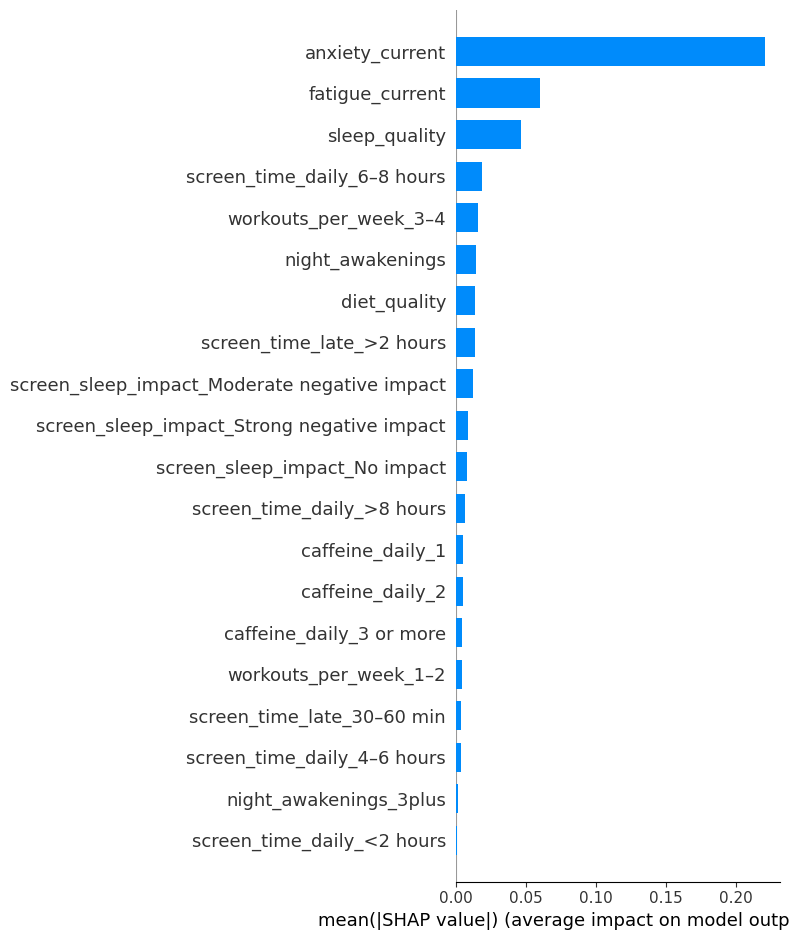

In [34]:
shap.summary_plot(shap_vals_class1, 
                  X_test_shap, 
                  plot_type="bar")


## Распределение влияния признаков (summary plot)
Этот график дополняет предыдущий:
он показывает не только важность, но и направление влияния признаков.

Можно увидеть:
- при каких значениях признак повышает стресс;
- при каких - снижает;
- насколько неоднородно его влияние среди людей.

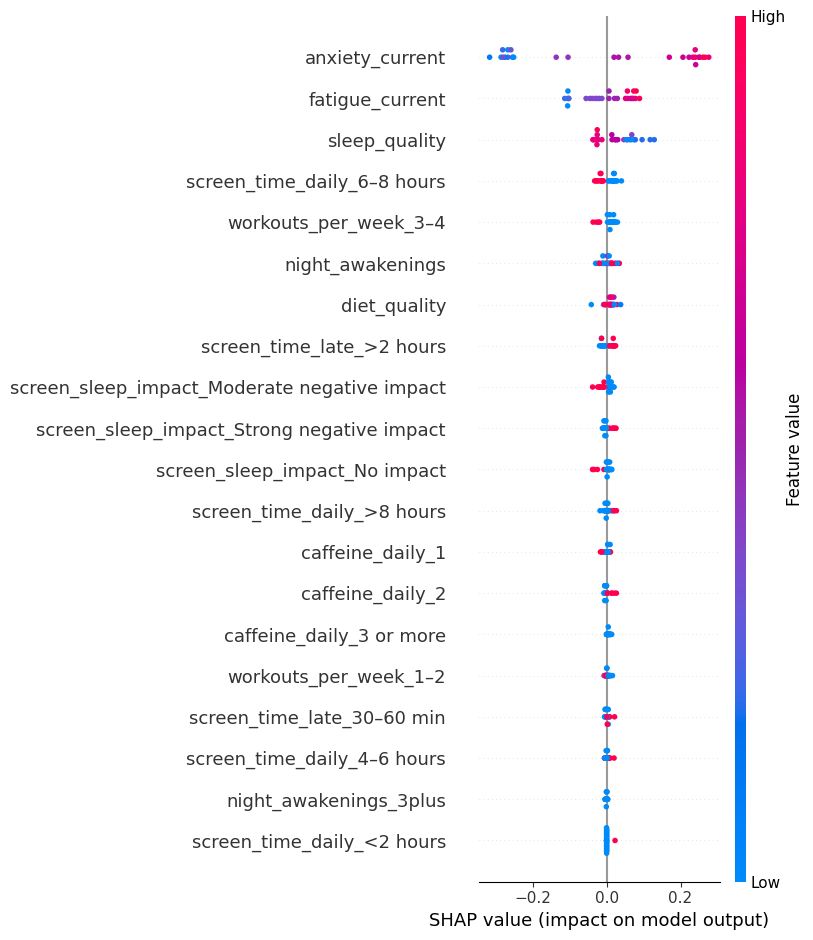

In [35]:
shap.summary_plot(
    shap_vals_class1,
    X_test_shap
)